In [1]:
import cv2
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# Load image and bbox
image = cv2.imread("./assets/colab/image_sportsfan.jpg")
with open('./assets/colab/bbox_sportsfan.json') as jsonfile:
    bbox = json.load(jsonfile)['bbox']

In [2]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework

# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))

SPIGA model loaded!


In [3]:
class FeatureHook:
    def __init__(self, module):
        self.module = module
        self.features = None
        self.hook = self.module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
        self.inp = input
    def remove(self):
        self.hook.remove()

# MTN Visualization

In [12]:
visualization = []

In [13]:
for i in range(3):
    fe = FeatureHook(processor.model.visual_cnn.outs_features[i])
    processor.forward(image, [bbox])
    visualization.append(fe.features)
    fe.remove()

In [16]:
output = visualization[1].reshape((98, 64, 64)).cpu()

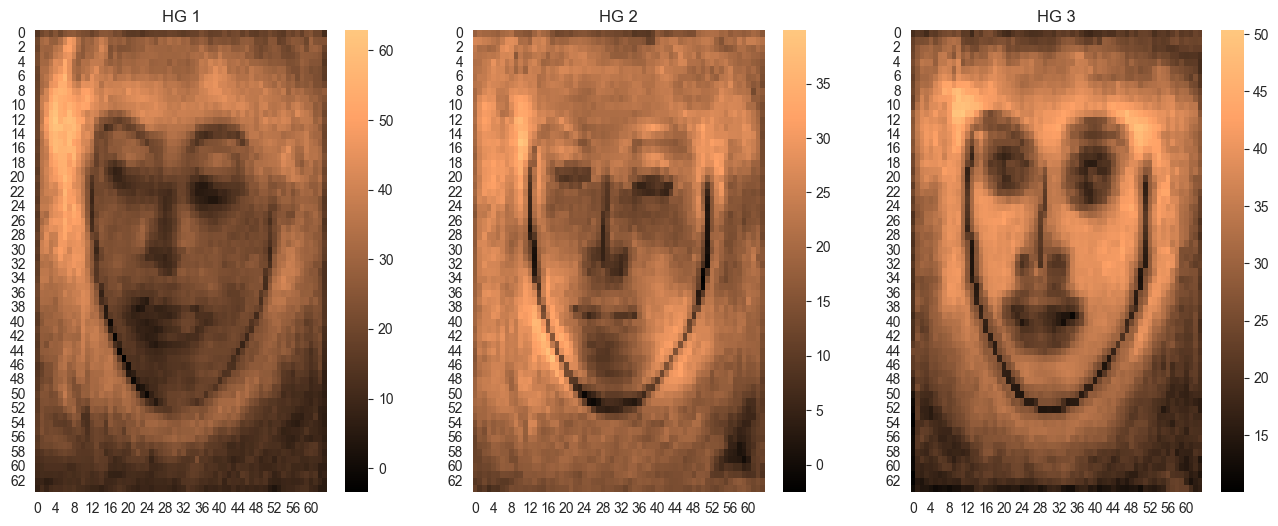

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for num, ax in enumerate(axes):
    output = visualization[num].reshape((98, 64, 64)).cpu()
    sns.heatmap(output[0].detach().numpy(), ax=ax, cmap='copper')
    ax.set_title(f'HG {num + 1}')
plt.show()

In [88]:
fe = FeatureHook(processor.model.visual_cnn)
processor.forward(image, [bbox])
output = fe.features
fe.remove()

C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


<Axes: >

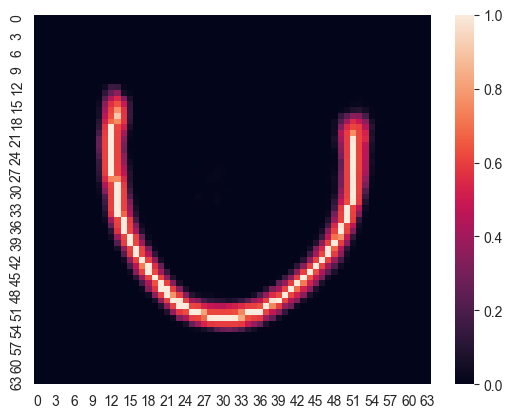

In [72]:
sns.heatmap(output['Heatmaps'][2][1].squeeze()[0].cpu().detach().numpy())

<Axes: >

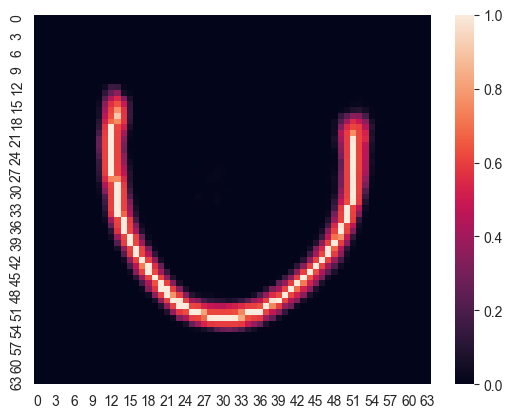

In [73]:
sns.heatmap(output['Heatmaps'][2][1].squeeze()[0].cpu().detach().numpy())

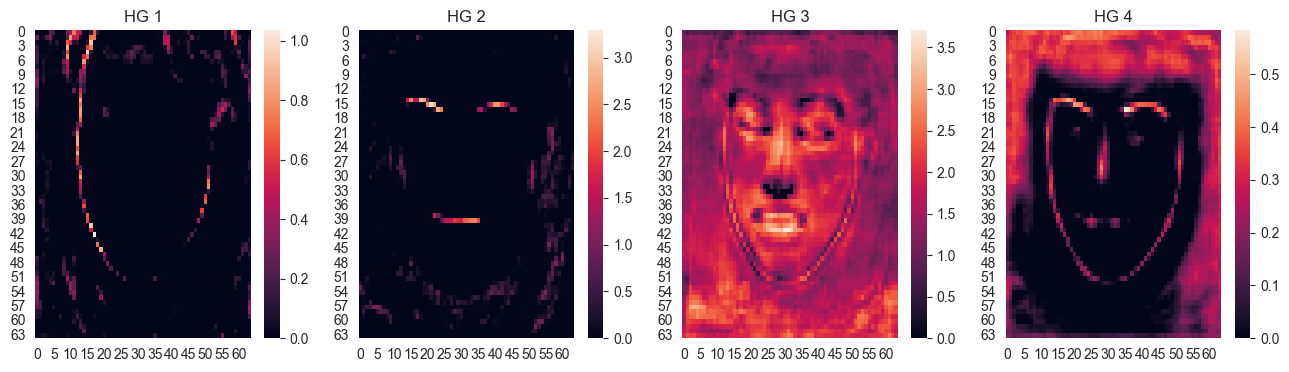

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=100)
for num, ax in enumerate(axes):
    sns.heatmap(output['VisualField'][num].squeeze()[3].cpu().detach().numpy(), ax=ax)
    ax.set_title(f'HG {num + 1}')
plt.show()

# Shape regressor visualization

In [36]:
features = processor.forward(image, [bbox])

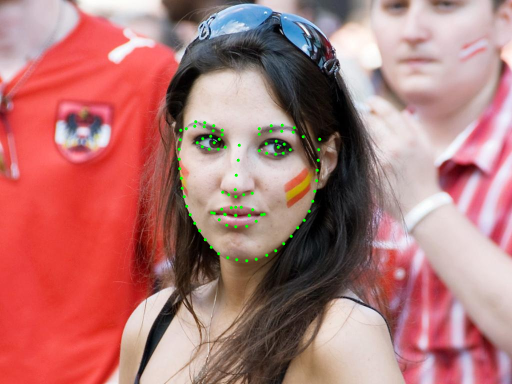

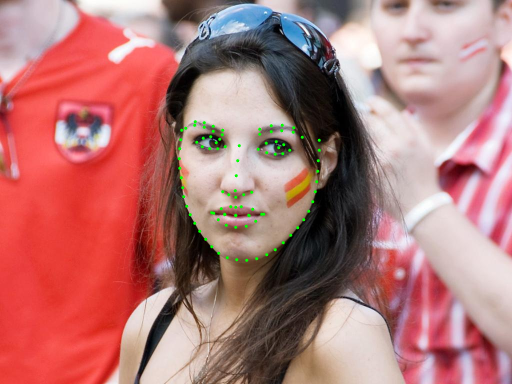

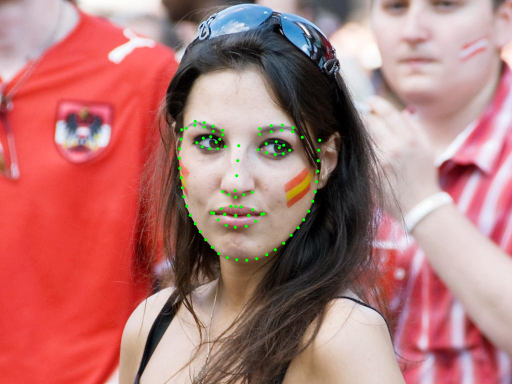

In [37]:
import copy
from spiga.demo.visualize.plotter import Plotter

ldm = []

crop_bboxes = np.array(processor.pretreat(image, [bbox])[1])
bboxes = np.array([bbox])
for i in range(3):
    landmarks = features['Landmarks'][i].cpu().detach().numpy()
    landmarks = landmarks.transpose((1, 0, 2))
    landmarks = landmarks*processor.model_cfg.image_size
    landmarks_norm = (landmarks - crop_bboxes[:, 0:2]) / crop_bboxes[:, 2:4]
    landmarks_out = (landmarks_norm * bboxes[:, 2:4]) + bboxes[:, 0:2]
    landmarks_out = landmarks_out.transpose((1, 0, 2))

    x0,y0,w,h = bbox
    canvas = copy.deepcopy(image)
    landmarks = landmarks_out.tolist()[0]

    plotter = Plotter()
    canvas = plotter.landmarks.draw_landmarks(canvas, landmarks)

    (h, w) = canvas.shape[:2]
    canvas = cv2.resize(canvas, (512, int(h*512/w)))
    canvas = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    display(canvas)

In [38]:
features.keys()

dict_keys(['VisualField', 'HGcore', 'Heatmaps', 'Pose', 'Landmarks', 'GATProb'])

In [49]:
features['GATProb'][-1].squeeze()[-1][0]grad_fn

tensor([3.2474e-03, 8.8632e-06, 1.6419e-08, 8.6197e-06, 8.8206e-06, 1.9955e-06,
        3.4782e-06, 8.6162e-08, 7.4797e-09, 3.8821e-10, 5.3454e-09, 1.3447e-11,
        4.0534e-09, 5.1478e-10, 7.8680e-07, 9.6899e-11, 5.1035e-08, 7.3853e-09,
        7.6386e-12, 8.5564e-08, 1.9965e-07, 2.1355e-08, 6.0805e-07, 6.1483e-10,
        1.4058e-09, 5.9823e-10, 1.7391e-06, 1.4835e-06, 2.2897e-07, 3.4148e-09,
        2.9717e-09, 6.0612e-06, 4.7271e-07, 1.7856e-04, 1.2122e-02, 8.2955e-06,
        7.3054e-03, 2.6475e-03, 2.7070e-06, 1.3017e-04, 1.8476e-07, 2.2977e-03,
        3.6399e-01, 1.1498e-02, 3.4166e-04, 5.8344e-01, 5.2569e-05, 1.4196e-03,
        2.9538e-06, 3.6364e-03, 1.1095e-05, 1.4247e-05, 5.8658e-08, 1.8375e-08,
        1.3013e-06, 1.9578e-07, 3.9003e-10, 1.5579e-08, 6.5985e-07, 1.1850e-08,
        7.7024e-05, 1.8376e-04, 2.7790e-05, 3.5913e-03, 2.8470e-05, 1.2012e-05,
        1.1754e-08, 7.8019e-06, 7.8550e-05, 4.2837e-05, 5.2308e-05, 1.5895e-03,
        3.7605e-05, 4.4335e-05, 1.5258e-

# Final output

C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
C:\Users\fapro\Desktop\SPIGA\venv\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


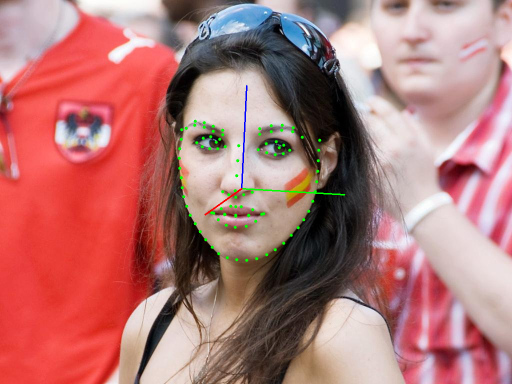

In [30]:
import copy
from spiga.demo.visualize.plotter import Plotter

#Inference
features = processor.inference(image, [bbox])
# Prepare variables
x0,y0,w,h = bbox
canvas = copy.deepcopy(image)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

# Plot features
plotter = Plotter()
canvas = plotter.landmarks.draw_landmarks(canvas, landmarks)
canvas = plotter.hpose.draw_headpose(canvas, [x0,y0,x0+w,y0+h], headpose[:3], headpose[3:], euler=True)

# Show image results
(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
canvas = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
display(canvas)